In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import seaborn as sns

from lif import lif_compute, spike_binary, id_synaptic_waveform
from ou_process import ouprocess_gaussian
from spike_sync import find_synced_spikes

sns.set()

In [8]:
NUM_NEURONS = 1000 # 100
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 1.0e3 # 50.0e3
tt = np.arange(0.0, t_stop, dt)
# p.dt = dt; p.tStop = t_stop; ????????
# tw = 100.0

In [9]:
V = np.zeros((tt.shape[0], NUM_NEURONS)) # Membrane potential per neuron

# Additive noise to individual neurons
ETA, _ = ouprocess_gaussian(5.0, dt, t_stop, NUM_NEURONS)

In [10]:
# Slow Signal
input_slow, _ = ouprocess_gaussian(50.0, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

F_binary = np.zeros((tt.shape[0], NUM_NEURONS))
avg_firing_rate = np.zeros(NUM_NEURONS)
a2 = 25.0 # pA; std of noise

I_total = a2*ETA + i_inj

In [11]:
EL = -70.0  # mV
# V_th = Th  # -50
V = np.ones((I_total.shape[1]))*EL

V_reset = -90.0

k = 0
total_time = len(I_total) - 1.0/dt
V_out = np.zeros(I_total.shape)

spike_reset_count = np.zeros((I_total.shape[1],1))

In [12]:
while k <= total_time:
    # LIF equation
    dq_dt = 1.0 / tau_V * (-1.0 * (V - EL) + R * I_total[k])
    V += dt*dq_dt
    
    # Spike
    spike = 50.0*np.greater_equal(V, V_th) # Spike
    spike_reset_add = ((int(1.0/dt)+1)*np.greater_equal(V, V_th))
    spike_reset_count = np.add(spike_reset_count, spike_reset_add[:,None])
    
    # No spike
    subthresh = np.multiply(np.equal(spike_reset_count, 0.0),V[:,None])
    reset = np.multiply(np.greater(spike_reset_count, 0.0),V_reset)
    reset_or_subthres = reset + subthresh
    no_spike = np.multiply(reset_or_subthres, np.less(V, V_th)[:,None]).flatten()
    
    V_out[k] = spike + no_spike
    V = np.multiply(V_out[k,:], np.equal(spike_reset_count, 0.0).flatten()) + reset.flatten()
    
    spike_reset_count = spike_reset_count - 1.0*np.greater(spike_reset_count, 0.0)
    
    k += 1
    
while k < V_out.shape[0]:
    V_out[k] = V
    k += 1

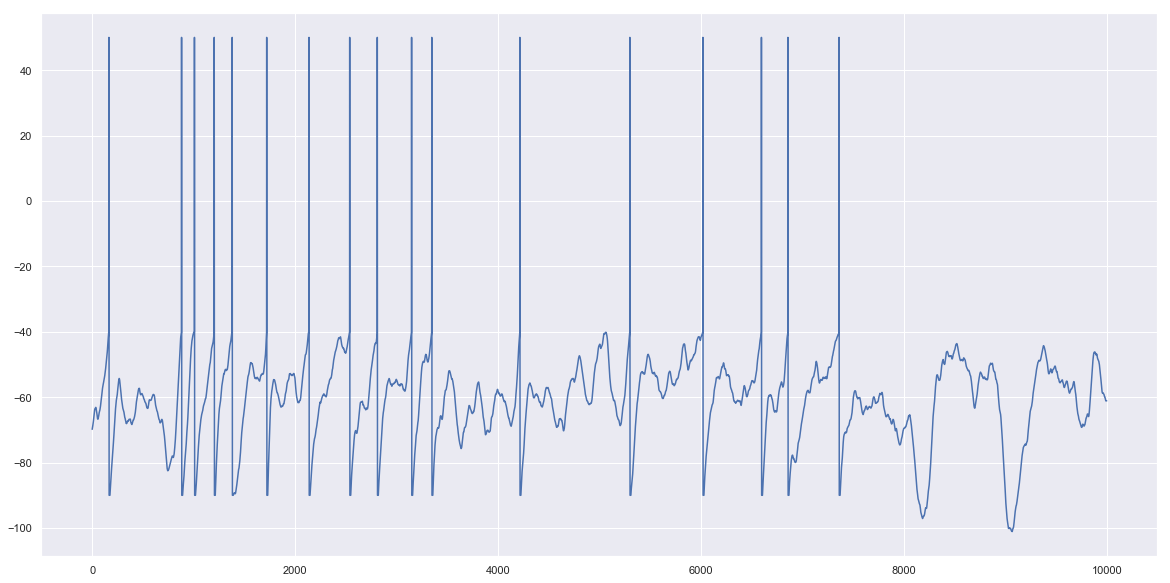

In [13]:
plt.figure(figsize=(20,10))
plt.plot(V_out[:,5])
# plt.plot(spike_reset_graph[:,4])

In [108]:
V_out[k].shape

(1000,)

In [109]:
spike_reset_count = spike_reset_count - 1.0*np.greater(spike_reset_count, 0.0)
k += 1

# # Spike
# if np.greater_equal(V, V_th): # V >= V_th:
#     V_out[k] = 50.0  # TODO: ???
#     V_out[k+1:int(k+1.0/dt)+1] = V_reset # TODO: ???
#     0:10+1 -> 11 steps

#     k += int(1.0/dt) # TODO: ???
# # No spike
# else:
#     V_out[k] = V
#     k += 1
V = V_out[k-1]

# while k < V_out.shape[0]:
#     V_out[k] = V
#     k += 1

In [35]:
# for k in range(0, NUM_NEURONS):
#     V[:,k] = lif_compute(I_total[:, k], R, tau_V, V_th, dt)
V = lif_compute(I_total, R, tau_V, V_th, dt)

ValueError: non-broadcastable output operand with shape (1000,1) doesn't match the broadcast shape (1000,1000)

In [ ]:
F_binary = spike_binary(V)
avg_firing_rate = np.sum(F_binary, axis=0)/(t_stop/1.0e3)

In [ ]:
plt.hist(avg_firing_rate)

In [ ]:
trial = 10
plt.figure(figsize=(20,5))
plt.plot(V[:,trial], color='plum')
plt.plot(F_binary[:,trial] * 40.0)
plt.show()

In [ ]:
F_binary.shape

In [ ]:
spike_inds, spike_trial = np.where(F_binary > 0)
plt.figure(figsize=(20,10))
plt.scatter(spike_inds, spike_trial, s=2)

In [ ]:
# ind = 0*1e3/p.dt+1:10*1e3/p.dt;
# q=2;
percentage_sync = 0.5
window_sync = 5
TW = 1
psth_total = np.sum(F_binary,axis=1) # Sum of spikes from all neurons at a given t
# psth_ = psth_total(ind);
indx_async, indx_sync, sync_event, M_S = find_synced_spikes(psth_total, percentage_sync, window_sync, TW, NUM_NEURONS, dt, t_stop)
# sig_sync = M_S;
# sig_async = not M_S;
# Sig_T{1}=sig_async(ind);
# Sig_T{2}=sig_sync(ind);
# sig_sync

In [ ]:
plt.plot(M_S)

In [ ]:
v_E = 0.0
v_ave = -67.0

tau_rise = 0.5
tau_fall = 5.0
syn_kernel_len = 50.0

syn_waveform = id_synaptic_waveform(dt, syn_kernel_len, tau_rise, tau_fall)
syn_wave_len = syn_waveform.shape[0]
t_steps = F_binary.shape[0]

In [ ]:
plt.plot(syn_waveform)

In [ ]:
F_synaptic = np.zeros(F_binary.shape)
for neuron in range(0, NUM_NEURONS):
    fr_fast = np.convolve(F_binary[:,neuron], syn_waveform)
    F_synaptic[:, neuron] = fr_fast[:-syn_wave_len+1]

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(F_synaptic[:,10])
# plt.plot(F_binary[:,10])

In [ ]:
ind_neur = np.arange(0, NUM_NEURONS)
Phi = F_synaptic[:t_steps, ind_neur]
X2 = -v_ave*np.ones((t_steps,ind_neur.shape[0])) + v_E

A = np.multiply(Phi, X2)
W, residuals, rank, s = np.linalg.lstsq(A, i_inj)
reconstructed = np.dot(A, W)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(i_inj)
plt.plot(reconstructed, 'plum')

In [ ]:
W.shape

In [ ]:
np.zeros((NUM_NEURONS, 1)).shape

In [ ]:
reconstructed.shape

In [ ]:
# TESTING OUT VECTORIZED
k = 0
I_total = i_inj + a2*ETA[:,k]
V[:,k] = lif_compute(I_total, R, tau_V, V_th, dt)
V_selected = V[:, k, None]